## Import necessary packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import hdf5plugin
import numpy as np
import anndata as ad
from scipy.sparse import csr_matrix
from CellPLM.utils import set_seed
from CellPLM.pipeline.cell_embedding import CellEmbeddingPipeline
import scanpy as sc
import matplotlib.pyplot as plt
import rapids_singlecell as rsc  # For faster evaluation, we recommend the installation of rapids_singlecell.

## Specify important parameters before getting started

In [2]:
PRETRAIN_VERSION = '20231027_85M'
DEVICE = 'cuda:1'

## Load Downstream Dataset

The example dataset here is from [GSE155468](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE155468).


In [3]:
set_seed(42)

data = ad.read_h5ad('../data/gse155468.h5ad')
data.obs_names_make_unique()

## Set up the pipeline

In [4]:
pipeline = CellEmbeddingPipeline(pretrain_prefix=PRETRAIN_VERSION, # Specify the pretrain checkpoint to load
                                 pretrain_directory='../ckpt')
pipeline.model

OmicsFormer(
  (embedder): OmicsEmbeddingLayer(
    (act): ReLU()
    (norm0): GroupNorm(4, 1024, eps=1e-05, affine=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (extra_linear): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): GroupNorm(4, 1024, eps=1e-05, affine=True)
    )
    (pe_enc): Sinusoidal2dPE(
      (pe_enc): Embedding(10000, 1024)
    )
    (feat_enc): OmicsEmbedder()
  )
  (mask_model): MaskBuilder()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): FlowformerLayer(
        (self_attn): Flow_Attention(
          (query_projection): Linear(in_features=1024, out_features=1024, bias=True)
          (key_projection): Linear(in_features=1024, out_features=1024, bias=True)
          (value_projection): Linear(in_features=1024, out_features=1024, bias=True)
          (out_projection): Linear(in_features=1024, out_features=1024, bias=True)
          (drop

## Evaluation and Inference

Once the pipeline is initialized, performing inference (cell embedding query) or evaluation on new datasets (with clustering metrics) can be easily accomplished using the built-in `predict` and `score` functions.

INFO:biothings.client:querying 1-1000...


Automatically converting gene symbols to ensembl ids...


INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-12382...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists 

After filtering, 9999 genes remain.


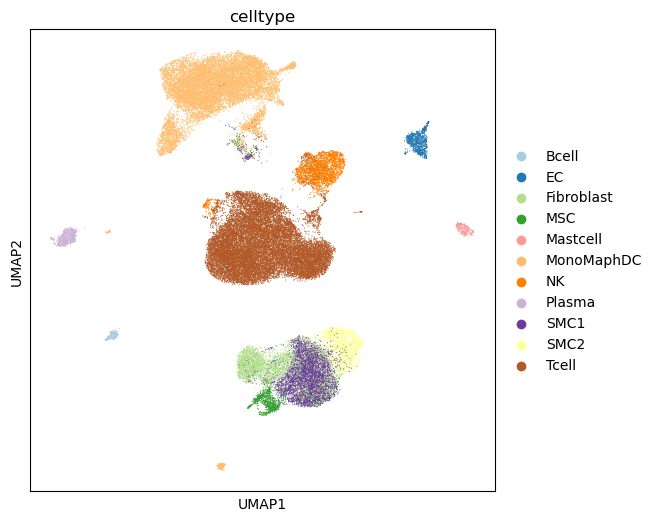

In [5]:
embedding = pipeline.predict(data, # An AnnData object
                device=DEVICE) # Specify a gpu or cpu for model inference

data.obsm['emb'] = embedding.cpu().numpy()
sc.pp.neighbors(data, use_rep='emb', method='rapids') # remove method='rapids' if rapids is not installed
sc.tl.umap(data, method='rapids') # remove method='rapids' if rapids is not installed
plt.rcParams['figure.figsize'] = (6, 6)
sc.pl.umap(data, color='celltype', palette='Paired')

In [6]:
pipeline.score(data, # An AnnData object
               label_fields=['celltype'],
               evaluation_config = {
                   'method': 'rapids', # change to 'scanpy' if 'rapids_singlecell' is not installed; the final scores may vary due to the implementation
                   'batch_size': 50000, # Specify batch size to limit gpu memory usage
               },
               device=DEVICE) # Specify a gpu or cpu for model inference

INFO:biothings.client:querying 1-1000...


Automatically converting gene symbols to ensembl ids...


INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-12382...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists 

After filtering, 9999 genes remain.


{'ari': 0.8650613891931775, 'nmi': 0.8417989883048135}